# Application & Tips
## Learning rate
### Gradient
- 기울기를 나타냄
- Learning rate와 기울기의 연관관계를 통해 최적의 값을 찾아낼 수 있음

### Good and Bad Learning rate
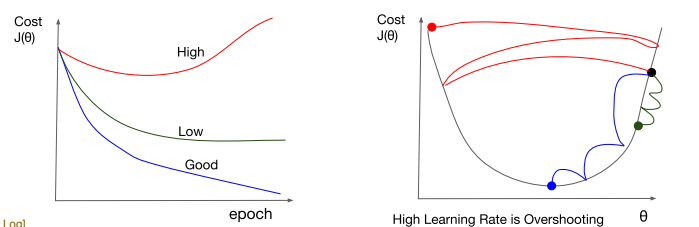
- learning rate가 너무 크면 오버 슈팅이 일어날 수 있음
- 적절한 learning rate를 정하는 것이 중요
- 일반적으로 많이 쓰는 learning rate는 0.01
(Adam optimizer를 사용할 경우 3e-4도 가능)

### Annealing the learning rate (Decay)
- learning rate의 조절
- Step decay, Exponential decay, 1/t decay가 있음
- 텐서플로우에서 라이브러리로 제공
---
## Data preprocessing
### Standardization / Normanalization
- Standardization (Mean Distance): 표준화 기법
$$\frac{x-u}{o} $$
- Normalization (0~1): 정규화 기법
$$\frac{x-x_{min}}{x_{max}-x_{min}}$$
- numpy library로 구현 가능

### Noisy Data
- 쓸모없는 데이터를 제거해 주는 것이 중요
---
## Overfitting
- 새로운 데이터로 테스트 할 경우 정확도가 떨어지는 경향을 보임
- 테스트 데이터와 평가 데이터가 모두 높은 accuracy를 보여야 함
- underfitting: 학습이 덜 된 상태

### Set a features
- 학습 데이터를 더 많이 넣음
- features의 수를 줄이는 것 (차원 줄이기)
- feature의 수를 증가 시킴: 모델이 너무 심플하면 의미가 사라져 구체화 시킬 필요가 있음

### Regularization (Add term to loss)
- loss값에 term을 줌으로써 해결 가능

### Solutions
- Feature Normalization
- Regularization
- More Data (Data Augmentation)
- Dropout (0.5 is common)
- Batch Normalization

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

tf.random.set_seed(777)  # for reproducibility

print(tf.__version__)

2.9.2


In [22]:
xy = np.array([[828.659973, 833.450012, 908100, 828.349976, 831.659973],
               [823.02002, 828.070007, 1828100, 821.655029, 828.070007],
               [819.929993, 824.400024, 1438100, 818.97998, 824.159973],
               [816, 820.958984, 1008100, 815.48999, 819.23999],
               [819.359985, 823, 1188100, 818.469971, 818.97998],
               [819, 823, 1198100, 816, 820.450012],
               [811.700012, 815.25, 1098100, 809.780029, 813.669983],
               [809.51001, 816.659973, 1398100, 804.539978, 809.559998]])

def normalization(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / denominator

xy = normalization(xy)

x_train = xy[:, 0:-1]
y_train = xy[:, [-1]]

In [23]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))

W = tf.Variable(tf.random.normal((4, 1)), dtype=tf.float32)
b = tf.Variable(tf.random.normal((1,)), dtype=tf.float32)

def linearReg_fn(features):
    hypothesis = tf.matmul(features, W) + b
    return hypothesis

def l2_loss(loss, beta = 0.01):
    W_reg = tf.nn.l2_loss(W) # output = sum(t ** 2) / 2
    loss = tf.reduce_mean(loss + W_reg * beta)
    return loss

def loss_fn(hypothesis, features, labels, flag = False):
    cost = tf.reduce_mean(tf.square(hypothesis - labels))
    if(flag):
        cost = l2_loss(cost)
    return cost

In [24]:
is_decay = True
starter_learning_rate = 0.1

if(is_decay):    
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=starter_learning_rate,
                                                                  decay_steps=50,
                                                                  decay_rate=0.96,
                                                                  staircase=True)
    optimizer = tf.keras.optimizers.SGD(learning_rate)
else:
    optimizer = tf.keras.optimizers.SGD(learning_rate=starter_learning_rate)

def grad(hypothesis, features, labels, l2_flag):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(linearReg_fn(features),features,labels, l2_flag)
    return tape.gradient(loss_value, [W,b]), loss_value

EPOCHS = 101

for step in range(EPOCHS):
    for features, labels  in dataset:
        features = tf.cast(features, tf.float32)
        labels = tf.cast(labels, tf.float32)
        grads, loss_value = grad(linearReg_fn(features), features, labels, False)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W,b]))        
    if step % 10 == 0:
        print("Iter: {}, Loss: {:.4f}".format(step, loss_value))

Iter: 0, Loss: 0.5695
Iter: 10, Loss: 0.3125
Iter: 20, Loss: 0.2145
Iter: 30, Loss: 0.1514
Iter: 40, Loss: 0.1094
Iter: 50, Loss: 0.0807
Iter: 60, Loss: 0.0612
Iter: 70, Loss: 0.0472
Iter: 80, Loss: 0.0369
Iter: 90, Loss: 0.0293
Iter: 100, Loss: 0.0236


## Data sets
### Training / Validation / Testing
- 데이터의 구성이 가장 중요

### Evaluating a hypothesis
- 모델이 선택된 후에는 아예 새로운 데이터를 만들어서 모델을 테스트 해 볼 수 있음

### Anomaly Detection
- 이상감지의 경우에는 새로운 방법으로 모델을 만듦
- GAN을 통해 건강한 데이터만을 가지고 모델을 만듦
- 특이한 데이터가 왔을 때 모델에서 Anomaly 검색 가능

## Learning
### Online Learning vs Batch Learning
| | online Learning | Batch(Offline) Learning |
|--------|:----------:|:-------------------------:|
|Data|Fresh|Static|
|Network|connected|disconnected|
|Model|Updating|Static|
|Weight|Tuning|initialize|
|Infra(GPU)|Always|Per call|
|Application|Realtime Process|Stopping|
|Priority|Speed|Correctness|

### Fine tuning / Feature Extraction
- Fine tuning: 기존의 모델에서 fine-tune이라는 방법(weight 값 미세하게 조절)으로 새로운 task을 만듦
- Reature Extraction: 기존의 모델을 만들어 놓은 상태에서 새로운 task에 대해서만 학습을 시킴

### Efficient Models
- inference 최소화 -> 모델의 weight 값을 줄여야 함
- 모델의 속도 중요


In [26]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

tf.random.set_seed(777)  # for reproducibility
print(tf.__version__)

2.9.2


4422102/4422102 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5064 - accuracy: 0.8233
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3788 - accuracy: 0.8635
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3403 - accuracy: 0.8756
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3137 - accuracy: 0.8846
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3640 - accuracy: 0.8719
Test accuracy: 0.8719000220298767


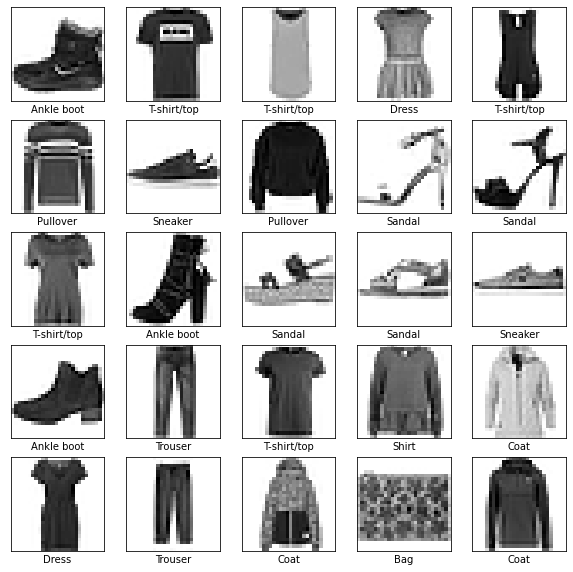

In [27]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_images = train_images / 255.0
test_images = test_images / 255.0

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

In [28]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

word_index = imdb.get_word_index()

word_index = {k:(v+3) for k,v in word_index.items()}
word_index[""] = 0 # 공백
word_index[""] = 1 # 시작 값
word_index[""] = 2 # unknown
word_index[""] = 3 #사용되지 않은 값

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(train_data[4])

1641221/1641221 [==============================] - 0s 0us/step


"? worst mistake of my life br br i picked this movie up at target for 5 because i figured hey it's sandler i can get some cheap laughs i was wrong completely wrong mid way through the film all three of my friends were asleep and i was still suffering worst plot worst script worst movie i have ever seen i wanted to hit my head up against a wall for an hour then i'd stop and you know why because it felt damn good upon bashing my head in i stuck that damn movie in the ? and watched it burn and that felt better than anything else i've ever done it took american psycho army of darkness and kill bill just to get over that crap i hate you sandler for actually going through with this and ruining a whole day of my life"

In [29]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index[""],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index[""],
                                                       padding='post',
                                                       maxlen=256)

print(len(train_data[0]), len(test_data[0]))
print(train_data[0])

256 256
[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  10

In [30]:
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model.evaluate(test_data, test_labels)
print(results)

Epoch 1/40
30/30 [==============================] - 2s 30ms/step - loss: 0.6920 - accuracy: 0.5456 - val_loss: 0.6903 - val_accuracy: 0.7050
Epoch 2/40
30/30 [==============================] - 1s 24ms/step - loss: 0.6868 - accuracy: 0.7304 - val_loss: 0.6827 - val_accuracy: 0.6979
Epoch 3/40
30/30 [==============================] - 1s 26ms/step - loss: 0.6751 - accuracy: 0.7422 - val_loss: 0.6679 - val_accuracy: 0.7182
Epoch 4/40
30/30 [==============================] - 1s 25ms/step - loss: 0.6541 - accuracy: 0.7606 - val_loss: 0.6435 - val_accuracy: 0.7663
Epoch 5/40
30/30 [==============================] - 1s 25ms/step - loss: 0.6223 - accuracy: 0.7875 - val_loss: 0.6095 - val_accuracy: 0.7730
Epoch 6/40
30/30 [==============================] - 1s 23ms/step - loss: 0.5802 - accuracy: 0.8063 - val_loss: 0.5678 - val_accuracy: 0.8012
Epoch 7/40
30/30 [==============================] - 1s 24ms/step - loss: 0.5314 - accuracy: 0.8261 - val_loss: 0.5227 - val_accuracy: 0.8176
Epoch 8/40
30